## MSc students LOFAR group 2025-2026
#### Week 1:
1. Join Slack
2. Download LOFAR and NVSS radio catalogues
3. Crossmatch VLASS and a LOFAR catalog and determine spectral indices (Extra: add NVSS as well to obtain a third flux measurement for your spectral index estimate)
3. Make a histogram of the spectral indices you found (you can use Python for this)
4. Take catalog and image of LOFAR deep field and plot interesting sources (e.g. Brightest, steepest spectral index, largest, or other properties you can think of)

##### Week 1, task 2
- LOFAR LoTSS DR2: https://lofar-surveys.org/dr2_release.html
- VLASS: https://cirada.ca/vlasscatalogueql0
- NVSS: https://www.cv.nrao.edu/nvss/anonftp.shtml -> obtain through ftp connection

##### Week 1, task 3

In [17]:
from astropy.table import Table
from astropy.coordinates import SkyCoord, match_coordinates_sky
from astropy.io import fits
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
from astropy import wcs

In [7]:
lotss_dr2_path = "CATALOGUES/LoTSS_DR3_v0.2_srl.fits" # Actually DR3
lotss_dr2 = fits.open(lotss_dr2_path)[1].data
print(lotss_dr2.columns)

vlass_path = "CATALOGUES/VLASS_QL2_hosts.csv"
vlass = Table.read(vlass_path)
print(vlass.columns)

nvss_path = "CATALOGUES/nvss.fits"
nvss = Table.read(nvss_path)
print(nvss.columns)

ColDefs(
    name = 'Source_Name'; format = '24A'
    name = 'RA'; format = 'D'; unit = 'deg'
    name = 'E_RA'; format = 'D'; unit = 'arcsec'
    name = 'DEC'; format = 'D'; unit = 'deg'
    name = 'E_DEC'; format = 'D'; unit = 'arcsec'
    name = 'Peak_flux'; format = 'D'; unit = 'beam-1 mJy'
    name = 'E_Peak_flux'; format = 'D'; unit = 'beam-1 mJy'
    name = 'Total_flux'; format = 'D'; unit = 'mJy'
    name = 'E_Total_flux'; format = 'D'; unit = 'mJy'
    name = 'Maj'; format = 'D'; unit = 'arcsec'
    name = 'E_Maj'; format = 'D'; unit = 'arcsec'
    name = 'Min'; format = 'D'; unit = 'arcsec'
    name = 'E_Min'; format = 'D'; unit = 'arcsec'
    name = 'DC_Maj'; format = 'D'; unit = 'arcsec'
    name = 'E_DC_Maj'; format = 'D'; unit = 'arcsec'
    name = 'DC_Min'; format = 'D'; unit = 'arcsec'
    name = 'E_DC_Min'; format = 'D'; unit = 'arcsec'
    name = 'PA'; format = 'D'; unit = 'deg'
    name = 'E_PA'; format = 'D'; unit = 'deg'
    name = 'DC_PA'; format = 'D'; unit = 'de

In [8]:
print(f"Number of LOFAR sources: {len(lotss_dr2)}")
print(f"Number of VLASS sources: {len(vlass)}")
print(f"Number of NVSS sources: {len(nvss)}")

Number of LOFAR sources: 13863735
Number of VLASS sources: 694973
Number of NVSS sources: 1773484


In [9]:
# vlass = vlass[vlass['Total_flux_source'] > 0.]
# print(f"Number of VLASS sources with positive flux: {len(vlass)}")

# lotss_dr2 = lotss_dr2[lotss_dr2['Total_flux'] > 0.]
# print(f"Number of LOFAR sources with positive flux: {len(lotss_dr2)}")

In [12]:
dec_mask = lotss_dr2['DEC'] > 60.0 # Filtering a little bit
print(f"Number of LOFAR sources above 30.0 declination: {sum(dec_mask)}")

lotss_dr2 = lotss_dr2[dec_mask]

Number of LOFAR sources above 30.0 declination: 2460180


In [13]:
lofar_coords = SkyCoord(ra=lotss_dr2["RA"], dec=lotss_dr2["DEC"], unit=(u.deg, u.deg), frame='icrs')
vlass_coords = SkyCoord(ra=vlass['RA_Source'], dec=vlass['DEC_Source'], unit=(u.deg, u.deg), frame='icrs')

idx_match_lofar_vlass, separations_lofar_vlass, _ = match_coordinates_sky(lofar_coords, vlass_coords)
mask_distance_lofar_vlass = (separations_lofar_vlass < 3.0 * u.arcsec)
print(f"Number of LOFAR sources matched to VLASS within 3 arcsec: {np.sum(mask_distance_lofar_vlass)}")

Number of LOFAR sources matched to VLASS within 3 arcsec: 52299


##### Week 1, task 4
Make a histogram of the spectral indices. We know that LOFAR collects data at a frequency of $144$ MHz and for VLASS this is $2-4$ GHz (let's assume $3$ GHz)

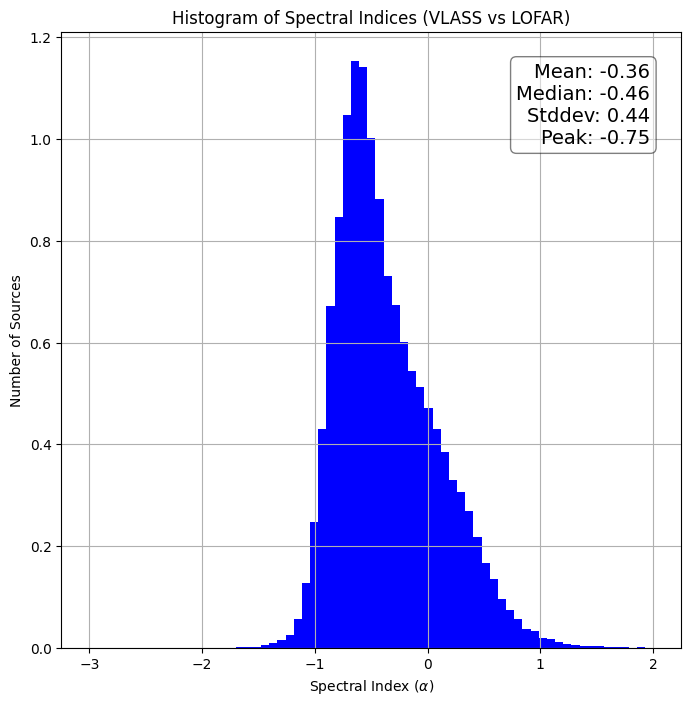

In [16]:
# Gather all information about fluxes and frequencies
lotss_freq = 144e6  # LOFAR frequency in Hz
vlass_freq = 3e9    # VLASS frequency in Hz
lofar_fluxes = lotss_dr2['Peak_flux'][mask_distance_lofar_vlass]
vlass_fluxes = vlass['Peak_flux_source'].data[idx_match_lofar_vlass][mask_distance_lofar_vlass]

# Calculate spectral indices
spectral_indices = np.log10(vlass_fluxes / lofar_fluxes) / np.log10(vlass_freq / lotss_freq)

# Plot histogram of spectral indices
plt.figure(figsize=(8, 8))
plt.hist(spectral_indices, bins=np.linspace(-3,2,70), color='blue', density=True)
plt.xlabel(r'Spectral Index ($\alpha$)')
plt.ylabel('Number of Sources')
plt.title('Histogram of Spectral Indices (VLASS vs LOFAR)')

# print some text in the top right corner with the mean and stddev of the spectral indices
mean_alpha = np.mean(spectral_indices)
median_alpha = np.median(spectral_indices)
std_alpha = np.std(spectral_indices)
peak_alpha = spectral_indices[np.argmax(np.histogram(spectral_indices, bins=np.linspace(-3,2,70))[0])]
textstr = f'Mean: {mean_alpha:.2f}\nMedian: {median_alpha:.2f}\nStddev: {std_alpha:.2f}\nPeak: {peak_alpha:.2f}'
plt.text(0.95, 0.95, textstr, transform=plt.gca().transAxes,
         fontsize=14, verticalalignment='top', horizontalalignment='right',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
#plt.yscale('log')
plt.grid()
plt.show()

##### Week 1, task 5
We plot the brightest sources in the centre of the ELAIS-N1 field

In [19]:
elais_n1_sources_path = "./CATALOGUES/en1_final_component_catalogue-v1.0.fits"
elais_n1_sources = Table.read(elais_n1_sources_path)
print(elais_n1_sources.columns)

elais_n1_image_path = "./IMAGES/en1_radio_image.fits"
elais_n1_image_hdu = fits.open(elais_n1_image_path)
elais_n1_image_data = elais_n1_image_hdu[0].data.squeeze().squeeze()
elais_n1_image_header = elais_n1_image_hdu[0].header
elais_n1_image_wcs = wcs.WCS(elais_n1_image_header).celestial
print(elais_n1_image_header)
print(np.shape(elais_n1_image_data))
print(elais_n1_image_wcs)

<TableColumns names=('Component_Name','RA','DEC','E_RA','E_DEC','Total_flux','E_Total_flux','Peak_flux','E_Peak_flux','S_Code','Maj','Min','PA','E_Maj','E_Min','E_PA','DC_Maj','DC_Min','DC_PA','Created','Deblended_from','Parent_Source')>


TypeError: buffer is too small for requested array

In [ ]:
from astropy.visualization import astropy_mpl_style, ImageNormalize, ZScaleInterval, PercentileInterval, AsinhStretch, SqrtStretch, SquaredStretch
from astropy.nddata import Cutout2D
from astropy.stats import sigma_clip

Number of sources in central ELAIS-N1 region: 4751
Number of sources with a flux greater than 0.1 Jy: 5


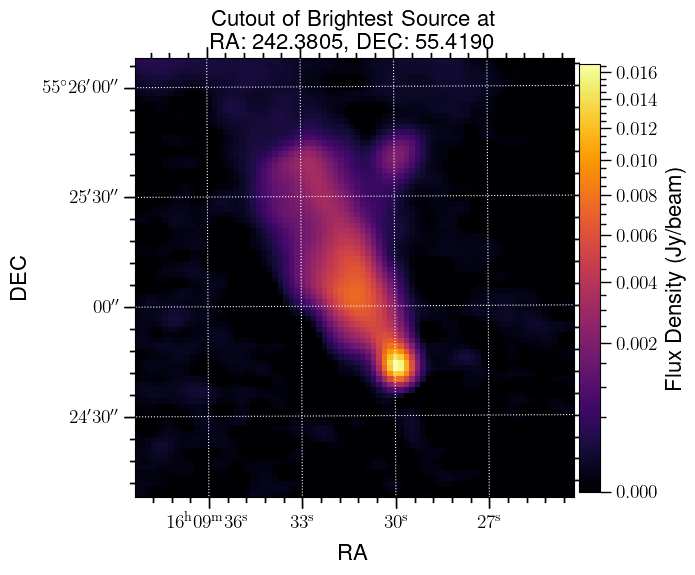

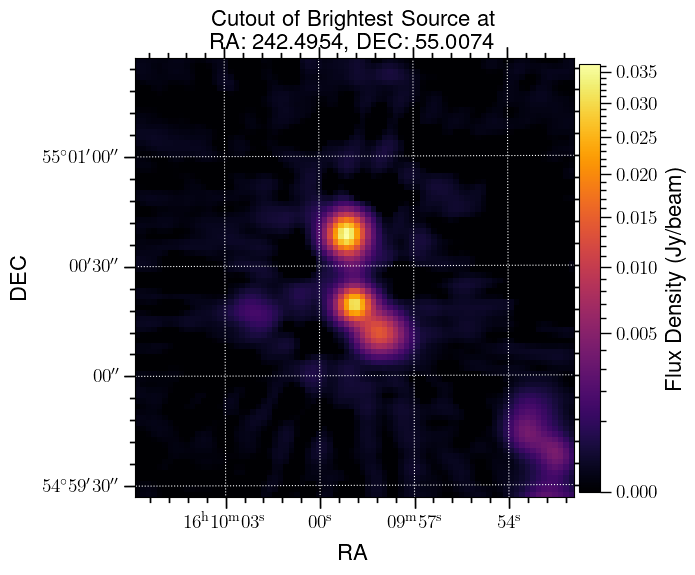

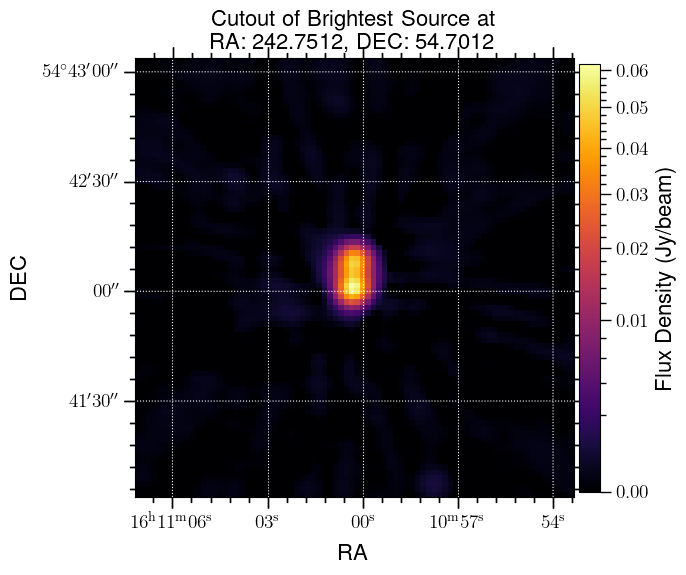

In [ ]:

# Select the brightest sources
mask_central_sources = (elais_n1_sources['RA'] > 242.0) & (elais_n1_sources['RA'] < 243.5) & (elais_n1_sources['DEC'] > 54.5) & (elais_n1_sources['DEC'] < 55.5)
print(f"Number of sources in central ELAIS-N1 region: {sum(mask_central_sources)}")
brightest_sources = elais_n1_sources[(elais_n1_sources['Total_flux'] > 0.1) & (mask_central_sources)]  # Flux threshold in Jy
print(f"Number of sources with a flux greater than 0.1 Jy: {len(brightest_sources)}")

# Make a cutout of one of the brightest sources in the ELAIS-N1 field
coords_brightest = SkyCoord(ra=brightest_sources['RA']*u.degree, dec=brightest_sources['DEC']*u.degree)
cutout_size = 5.0*u.arcmin

n=0
for i in range(len(coords_brightest)):
    if n == 3:
        break
    try:
        cutout = Cutout2D(elais_n1_image_data, position=coords_brightest[i], size=(cutout_size, cutout_size), wcs=elais_n1_image_wcs)
        n += 1
    except Exception as e:
        #print(f"Could not create cutout for source at RA: {coords_brightest[i].ra.degree}, DEC: {coords_brightest[i].dec.degree}. Error: {e}")
        continue
     
    # Determine local rms noise to define normalization
    filtered_image = sigma_clip(cutout.data, sigma=3, maxiters=7)
    rms_noise = np.sqrt(np.mean(filtered_image**2))
    norm = ImageNormalize(vmin=0., vmax=np.max(cutout.data), stretch=SqrtStretch(), interval=PercentileInterval(99.9))
     
    fig, ax = plt.subplots(figsize=(6,6), subplot_kw={'projection': cutout.wcs})
    plt.imshow(cutout.data, origin='lower', cmap='inferno', norm=norm)
    plt.colorbar(label='Flux Density (Jy/beam)', pad=0.01, fraction=0.046)
    plt.title(f'Cutout of Brightest Source at \nRA: {coords_brightest[i].ra.degree:.4f}, DEC: {coords_brightest[i].dec.degree:.4f}')
    plt.xlabel('RA')
    plt.ylabel('DEC')
    plt.grid(color='white', ls='dotted')
    plt.show()